
#install and import required packages

In [ ]:
!pip install -q transformers
!pip install -q tensorflow
!pip install -q livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForTokenClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

#import data directly from kaggle

In [ ]:
#@title Kaggle Credential { display-mode: "form" }

username = '' #@param {type: "string"}
api_key = '' #@param {type: "string"}


if username and api_key:
    token = {"username": username, "key": api_key}

    !mkdir ~/.kaggle
    !mkdir /content/.kaggle
    with open('/content/.kaggle/kaggle.json', 'w') as f:
        json.dump(token, f)

    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d shayanbemanian/arman-persian-ner-dataset

!unzip arman-persian-ner-dataset.zip

  0% 0.00/2.02M [00:00<?, ?B/s]
100% 2.02M/2.02M [00:00<00:00, 182MB/s]
Archive:  arman-persian-ner-dataset.zip
  inflating: dev.txt                 
  inflating: test.txt                
  inflating: train.txt               


#data exploration and cleaning

In [ ]:
columns = ['word', 'IOB_tag']

#The dataset consists of three fold
data_part1 = pd.read_csv('train.txt',names=columns, delimiter=' ')
data_part2 = pd.read_csv('dev.txt',names=columns, delimiter=' ')
data_part3 = pd.read_csv('test.txt',names=columns, delimiter=' ')

#data concatenation
data = pd.concat([data_part1, data_part2, data_part3])
print('shape of dataframe is: ', data.shape, '\n', '-----------------------------------')
data.head(5)

shape of dataframe is:  (731635, 2) 
 -----------------------------------


,word,IOB_tag
0,به,O
1,عنوان,O
2,مثال,O
3,وقتی,O
4,نشریات,O


In [ ]:
data.isnull().sum()

word       0
IOB_tag    0
dtype: int64

In [ ]:
words=list(set(data['word']))

nu_words=len(words)
print('number of unique words: ', nu_words)

number of unique words:  18079


In [ ]:
tags=list(set(data['IOB_tag']))

nu_tags=len(tags)
print('number of unique tags: ', nu_tags)

number of unique tags:  13


In [ ]:
data['IOB_tag'].value_counts()

O          659513
I-org       15886
B-org       13114
B-loc        9899
B-pers       9449
I-event      5574
I-pers       5515
I-fac        2730
I-loc        2567
I-pro        2060
B-pro        2054
B-event      1667
B-fac        1607
Name: IOB_tag, dtype: int64

In [ ]:
pie = data['IOB_tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

In [ ]:
def create_sequences(data, sentence_delimiters=['.', '?', '!']):

    # Group the data by sentence delimiter
    grouped = data.groupby((data['word'].isin(sentence_delimiters)).cumsum())

    #convert string tag to integer tag
    le_tags = LabelEncoder()
    data.loc[:, 'IOB_tag'] = le_tags.fit_transform(data['IOB_tag'])

    # Extract the words and tags for each group using a list comprehension
    sentences_list = [group['word'].tolist() for _, group in grouped]
    tags_list = [group['IOB_tag'].tolist() for _, group in grouped]

    # Return the list of sentences and list of tags
    return sentences_list, tags_list


In [ ]:
sentences_list, tags_list = create_sequences(data)
print(sentences_list[1:2], "\n", tags_list[1:2] )

[['.', 'دکتر', 'اصغری', 'دبیر', 'چهارمین', 'همایش', 'انجمن', 'زمین\u200cشناسی', 'ایران', 'در', 'این', 'زمینه', 'گفت', ':', 'از', 'مجموع', 'چهار', 'صد', 'مقاله', 'رسیده', 'به', 'دبیرخانه', 'همایش', '،', 'يك', 'صد', 'و', 'هشتاد', 'مقاله', 'ظرف', 'مدت', 'دو', 'روز', 'در', 'هشت', 'سالن', 'همایش', 'برگزار', 'شد']] 
 [[12, 12, 4, 12, 0, 6, 6, 6, 6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]]


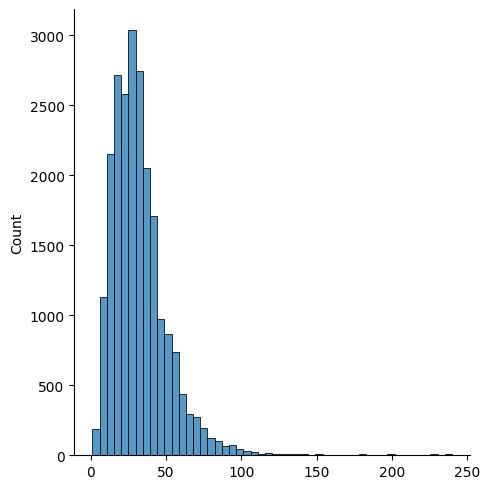

In [ ]:
#Word length distribution
sns.displot([len(s) for s in sentences_list], bins=50)
plt.show()

In [ ]:
max_len = max([len(s) for s in sentences_list])
min_len = min([len(s) for s in sentences_list])

print ('Max_len:', max_len, '    ***    ', 'min_len:', min_len)

Max_len: 240     ***     min_len: 1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences_list,tags_list, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
# y_train Padding
train_tag = list()
for i in range(len(y_train)):
    #The number 12 refers to the 'O' tag
    train_tag.append(np.array(y_train[i] + [12] * (max_len-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{240}

In [ ]:
# y_val Padding
val_tag = list()
for i in range(len(y_val)):
    val_tag.append(np.array(y_val[i] + [12] * (max_len-len(y_val[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(val_tag)):
    was.append(len(val_tag[i]))
set(was)

{240}

In [ ]:
# y_test Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [12] * (max_len-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{240}

In [ ]:
y_train = to_categorical(train_tag, num_classes=nu_tags)
y_val = to_categorical(val_tag, num_classes=nu_tags)
y_test = to_categorical(test_tag, num_classes=nu_tags)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(18356, 240, 13)
(2040, 240, 13)
(2267, 240, 13)


In [ ]:
#config

MODEL_NAME_OR_PATH = "HooshvareLab/bert-fa-base-uncased"
MAX_LEN = max_len
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = AutoConfig.from_pretrained(MODEL_NAME_OR_PATH)
config.num_labels = nu_tags

def tokenize(data, max_len=MAX_LEN):
    tokenized_data = tokenizer(
        text=data,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,  #because we dont have pair sentence
        return_attention_mask=True,
        is_split_into_words=True,  #This is useful for NER or token classification task
        verbose=True
    )
    return tokenized_data

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

In [ ]:
X_train = tokenize(X_train)
X_test = tokenize(X_test)
X_val = tokenize(X_val)

X_train = {
    'input_ids': np.array(X_train['input_ids']),
    'attention_mask': np.array(X_train['attention_mask'])
}
X_test = {
    'input_ids': np.array(X_test['input_ids']),
    'attention_mask': np.array(X_test['attention_mask'])
}
X_val = {
    'input_ids': np.array(X_val['input_ids']),
    'attention_mask': np.array(X_val['attention_mask'])
}


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(TRAIN_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(TEST_BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(VALID_BATCH_SIZE)

#model bulding and training

In [ ]:
def build_model(model_name, config, learning_rate=LEARNING_RATE):
    model = TFAutoModelForTokenClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.CategoricalAccuracy("categorical_accuracy")

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

tf_model.h5:   0%|          | 0.00/963M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162250752 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  9997      
                                                                 
Total params: 162260749 (618.98 MB)
Trainable params: 162260749 (618.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


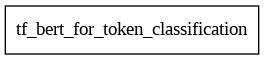

In [ ]:
tf.keras.utils.plot_model(model)

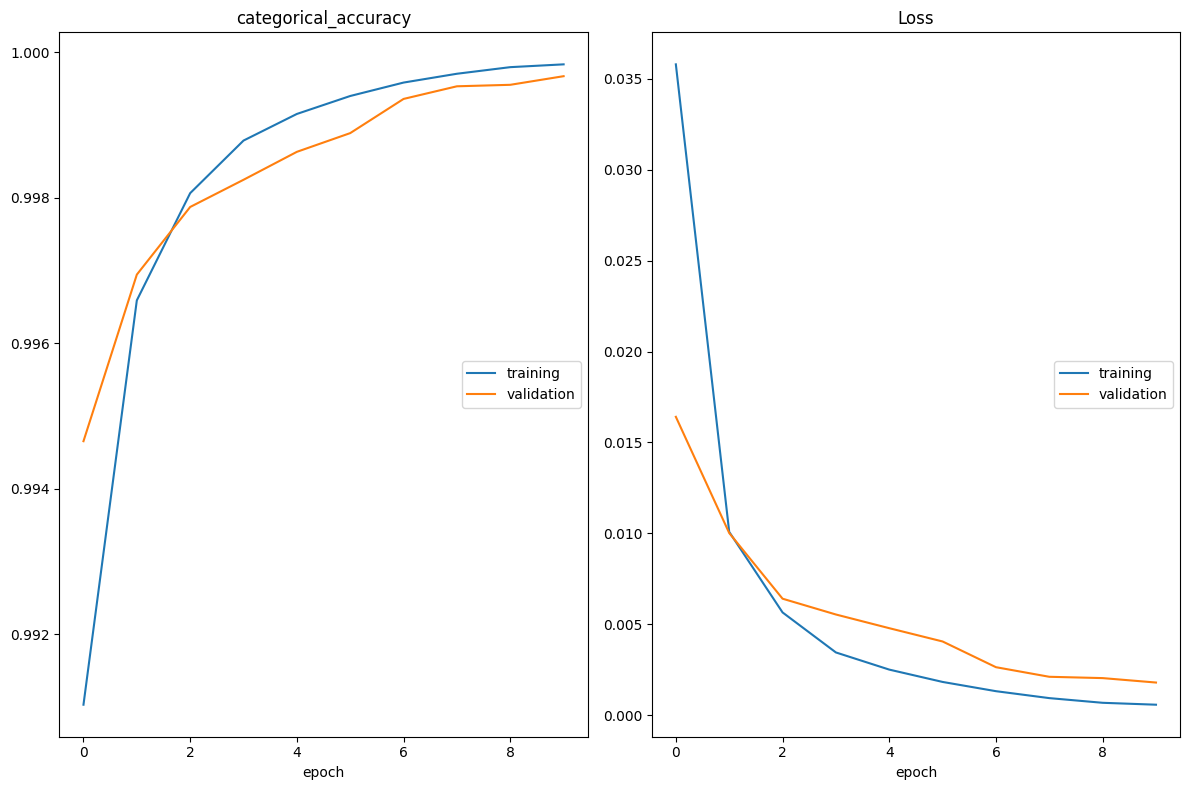

categorical_accuracy
	training         	 (min:    0.991, max:    1.000, cur:    1.000)
	validation       	 (min:    0.995, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    0.036, cur:    0.001)
	validation       	 (min:    0.002, max:    0.016, cur:    0.002)
1148/1148 [==============================] - 963s 839ms/step - loss: 5.8366e-04 - categorical_accuracy: 0.9998 - val_loss: 0.0018 - val_categorical_accuracy: 0.9997


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

#model evaluation

In [ ]:
#evaluate model
model.evaluate(X_test, np.array(y_test))

71/71 [==============================] - 37s 526ms/step - loss: 0.0019 - categorical_accuracy: 0.9996


[0.0018518493743613362, 0.9996305704116821]

In [ ]:
le_tags = LabelEncoder()
data.loc[:, 'IOB_tag'] = le_tags.fit_transform(data['IOB_tag'])


y_pred_logits = model.predict(X_test)
y_pred = tf.argmax(y_pred_logits.logits, axis=-1)
y_pred_labels = le_tags.inverse_transform(np.array(y_pred).reshape(-1))
y_true_labels = np.array(test_tag).flatten()
encoded_pred_labels = le_tags.transform(y_pred_labels)

report = classification_report(y_true_labels, y_pred_labels)
print(report)


71/71 [==============================] - 38s 532ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       158
           1       0.99      0.97      0.98       176
           2       0.98      0.98      0.98       966
           3       0.97      0.98      0.98      1314
           4       0.98      0.98      0.98       915
           5       0.99      0.97      0.98       183
           6       1.00      0.99      1.00       565
           7       1.00      0.98      0.99       308
           8       1.00      0.97      0.98       251
           9       0.98      0.99      0.98      1565
          10       0.97      0.98      0.98       533
          11       0.97      0.97      0.97       154
          12       1.00      1.00      1.00    536992

    accuracy                           1.00    544080
   macro avg       0.99      0.98      0.98    544080
weighted avg       1.00      1.00      1.00    544080

